In [1]:
import os
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from timm import create_model
import lpips
import torchvision.transforms.functional as TF
import cv2
import pytorch_msssim
import torchvision.transforms as T


In [2]:
# ============ Dataset with Preprocessing + Augmentation ============ #
class UIEBDataset(Dataset):
    def __init__(self, raw_dir, ref_dir, transform=None, use_hist_eq=True, augment=False):
        self.raw_files = sorted(os.listdir(raw_dir))
        self.ref_files = sorted(os.listdir(ref_dir))
        self.raw_dir = raw_dir
        self.ref_dir = ref_dir
        self.use_hist_eq = use_hist_eq
        self.transform = transform
        self.augment = augment  # train / val / test

        assert len(self.raw_files) == len(self.ref_files), "raw and ref images counts are inconsistent!"
        assert self.raw_files == self.ref_files, "Raw and reference files do not match!"

        self.color_augment = T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)

    # --------- Preprocessing ---------
    def _preprocess_raw_image(self, pil_image):
        bgr_image = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)
        image_hsv = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(image_hsv)

        # 均衡化 V (亮度) 通道
        v_eq = cv2.equalizeHist(v)

        # 提升 S (饱和度)
        s = np.clip(cv2.add(s, 10), 0, 255).astype(np.uint8)

        # Gamma 矫正
        gamma = 0.9
        v_gamma = np.uint8(np.power(v_eq / 255.0, gamma) * 255)

        final_hsv = cv2.merge([h, s, v_gamma])
        final_rgb = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2RGB)
        return Image.fromarray(final_rgb)

    def __len__(self):
        return len(self.raw_files)

    def __getitem__(self, idx):
        raw_path = os.path.join(self.raw_dir, self.raw_files[idx])
        ref_path = os.path.join(self.ref_dir, self.ref_files[idx])

        raw_img_pil = Image.open(raw_path).convert("RGB")
        ref_img_pil = Image.open(ref_path).convert("RGB")

        # only train时做增强
        if self.augment == 'train':
            raw_img_pil = self._preprocess_raw_image(raw_img_pil)
            ref_img_pil = self._preprocess_raw_image(ref_img_pil)

            if torch.rand(1) < 0.5:
                raw_img_pil = raw_img_pil.transpose(Image.FLIP_LEFT_RIGHT)
                ref_img_pil = ref_img_pil.transpose(Image.FLIP_LEFT_RIGHT)


            color_augment = T.ColorJitter.get_params(brightness=(0.8, 1.2), 
                                                     contrast=(0.8, 1.2), 
                                                     saturation=(0.8, 1.2), 
                                                     hue=(-0.1, 0.1))
                                                     
            raw_img_pil = TF.adjust_brightness(raw_img_pil, color_augment[1])
            ref_img_pil = TF.adjust_brightness(ref_img_pil, color_augment[1])
            
            raw_img_pil = TF.adjust_contrast(raw_img_pil, color_augment[2])
            ref_img_pil = TF.adjust_contrast(ref_img_pil, color_augment[2])
            
            raw_img_pil = TF.adjust_saturation(raw_img_pil, color_augment[3])
            ref_img_pil = TF.adjust_saturation(ref_img_pil, color_augment[3])
            
            raw_img_pil = TF.adjust_hue(raw_img_pil, color_augment[4])
            ref_img_pil = TF.adjust_hue(ref_img_pil, color_augment[4])

        if self.transform:
            raw_img = self.transform(raw_img_pil)
            ref_img = self.transform(ref_img_pil)

        return raw_img, ref_img

In [3]:
# # ============ Dataset ============ #
# class UIEBDataset(Dataset):
#     def __init__(self, raw_dir, ref_dir, transform=None):
#         self.raw_files = sorted(os.listdir(raw_dir))
#         self.ref_files = sorted(os.listdir(ref_dir))
#         self.raw_dir = raw_dir
#         self.ref_dir = ref_dir
#         self.transform = transform

#     def __len__(self):
#         return len(self.raw_files)

#     def __getitem__(self, idx):
#         raw_path = os.path.join(self.raw_dir, self.raw_files[idx])
#         ref_path = os.path.join(self.ref_dir, self.ref_files[idx])
#         raw_img = Image.open(raw_path).convert('RGB')
#         ref_img = Image.open(ref_path).convert('RGB')
#         if self.transform:
#             raw_img = self.transform(raw_img)
#             ref_img = self.transform(ref_img)
#         return raw_img, ref_img

In [4]:

# Work for Concate:
# class FeatureExtractor(nn.Module):
#     def __init__(self, arch="vit_base_patch16_224", img_size=128, out_dim=128):
#         super().__init__()
#         self.backbone = create_model(arch, pretrained=True, num_classes=0, img_size=img_size)
#         self.proj = nn.Linear(self.backbone.num_features, out_dim)
#     def forward(self, x):
#         feat = self.backbone.forward_features(x)  # [B, N, C] 或 [B, C, H, W]
#         if feat.ndim == 3:  # ViT 的输出: [B,N,C]
#             feat = feat.mean(1)  # GAP -> [B,C]
#         elif feat.ndim == 4:  # Swin 的输出: [B,C,H,W]
#             feat = feat.permute(0, 3, 1, 2)
#             feat = feat.mean(dim=(2, 3))  # GAP -> [B,C]
#         return self.proj(feat)  # [B,out_dim]

class FeatureExtractor(nn.Module):
    def __init__(self, arch="vit_base_patch16_224", img_size=128, out_dim=256):
        super().__init__()
        self.backbone = create_model(arch, pretrained=True, num_classes=0, img_size=img_size)
        self.proj = nn.Linear(self.backbone.num_features, out_dim)

        # ImageNet mean/std
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
        std  = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
        self.register_buffer("mean", mean, persistent=False)
        self.register_buffer("std", std, persistent=False)

    def forward(self, x):
        x = x.to(self.mean.device)
        x = (x + 1.0) * 0.5
        x = (x - self.mean) / self.std

        feat = self.backbone.forward_features(x)  # [B, N, C] (ViT) 或 [B, H, W, C] (Swin)
        if feat.ndim == 3:      # ViT → [B,N,C]
            seq = self.proj(feat)                # [B,N,out_dim]
        elif feat.ndim == 4:    # Swin → [B,H,W,C]
            B,H,W,C = feat.shape
            feat = feat.view(B, H*W, C)
            seq = self.proj(feat)                # [B,N,out_dim]
        return seq

class CrossAttention(nn.Module):
    def __init__(self, dim, cond_dim, n_heads=4):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=n_heads, batch_first=True)
        self.cond_proj = nn.Linear(cond_dim, dim)

    def forward(self, x, cond_seq):
        # x: [B,C,H,W] → flatten → [B,H*W,C]
        B,C,H,W = x.shape
        q = x.permute(0,2,3,1).reshape(B, H*W, C)  # [B,Nq,C]
        q = self.norm(q)
        kv = self.cond_proj(cond_seq)              # [B,Nc,C]
        out, _ = self.attn(q, kv, kv)
        out = out.view(B,H,W,C).permute(0,3,1,2)   # 回到 [B,C,H,W]
        return out + x

# ---------------- Cosine beta schedule ----------------
def cosine_beta_schedule(n_steps, s=0.008, device="cpu"):
    steps = n_steps + 1
    x = torch.linspace(0, n_steps, steps, device=device) / n_steps
    alphas_cumprod = torch.cos((x + s) / (1 + s) * math.pi / 2) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return betas.clamp(1e-8, 0.999)

# ---------------- UNet (GroupNorm+SiLU) ----------------
def conv_block(in_c, out_c, groups=8):
    return nn.Sequential(
        nn.Conv2d(in_c, out_c, 3, padding=1),
        nn.GroupNorm(groups, out_c),
        nn.SiLU(inplace=True),
        nn.Conv2d(out_c, out_c, 3, padding=1),
        nn.GroupNorm(groups, out_c),
        nn.SiLU(inplace=True),
    )

class CondUNet(nn.Module):
    def __init__(self, c_in=7, c_out=3, base=64, cond_dim=256):
        super().__init__()
        self.cond_dim = cond_dim
        self.enc1 = conv_block(c_in + cond_dim, base)     # 加条件通道
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = conv_block(base, base*2)
        self.pool2 = nn.MaxPool2d(2)
        self.bott = conv_block(base*2, base*4)
        self.up1  = nn.ConvTranspose2d(base*4, base*2, 2, 2)
        self.dec1 = conv_block(base*4, base*2)
        self.up2  = nn.ConvTranspose2d(base*2, base, 2, 2)
        self.dec2 = conv_block(base*2, base)
        self.outc = nn.Conv2d(base, c_out, 1)

    def forward(self, x, cond_vec):  # cond_vec: [B,cond_dim]
        B, _, H, W = x.shape
        cond_map = cond_vec.view(B, self.cond_dim, 1, 1).expand(B, self.cond_dim, H, W)
        x = torch.cat([x, cond_map], dim=1)
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        b  = self.bott(self.pool2(e2))
        u1 = self.up1(b)
        d1 = self.dec1(torch.cat([u1, e2], dim=1))
        u2 = self.up2(d1)
        d2 = self.dec2(torch.cat([u2, e1], dim=1))
        return self.outc(d2)

class CondUNetCA(nn.Module):
    def __init__(self, c_in=4, c_out=3, base=64, cond_dim=128):
        super().__init__()
        # ---- Encoder ----
        self.enc1 = conv_block(c_in, base)
        self.ca1  = CrossAttention(base, cond_dim)

        self.pool1 = nn.MaxPool2d(2)
        self.enc2  = conv_block(base, base*2)
        self.ca2   = CrossAttention(base*2, cond_dim)

        self.pool2 = nn.MaxPool2d(2)
        self.enc3  = conv_block(base*2, base*4)
        self.ca3   = CrossAttention(base*4, cond_dim)

        self.pool3 = nn.MaxPool2d(2)
        self.bott  = conv_block(base*4, base*8)
        self.ca_b  = CrossAttention(base*8, cond_dim)

        # ---- Decoder ----
        self.up3  = nn.ConvTranspose2d(base*8, base*4, 2, 2)
        self.dec3 = conv_block(base*8, base*4)
        self.ca_d3 = CrossAttention(base*4, cond_dim)

        self.up2  = nn.ConvTranspose2d(base*4, base*2, 2, 2)
        self.dec2 = conv_block(base*4, base*2)
        self.ca_d2 = CrossAttention(base*2, cond_dim)

        self.up1  = nn.ConvTranspose2d(base*2, base, 2, 2)
        self.dec1 = conv_block(base*2, base)
        self.ca_d1 = CrossAttention(base, cond_dim)

        # ---- Output ----
        self.outc = nn.Conv2d(base, c_out, 1)

    def forward(self, x, cond_seq):
        # ---- Encoder ----
        e1 = self.enc1(x)
        e1 = self.ca1(e1, cond_seq)

        e2 = self.enc2(self.pool1(e1))
        e2 = self.ca2(e2, cond_seq)

        e3 = self.enc3(self.pool2(e2))
        e3 = self.ca3(e3, cond_seq)

        b  = self.bott(self.pool3(e3))
        b  = self.ca_b(b, cond_seq)

        # ---- Decoder ----
        u3 = self.up3(b)
        d3 = self.dec3(torch.cat([u3, e3], dim=1))
        d3 = self.ca_d3(d3, cond_seq)

        u2 = self.up2(d3)
        d2 = self.dec2(torch.cat([u2, e2], dim=1))
        d2 = self.ca_d2(d2, cond_seq)

        u1 = self.up1(d2)
        d1 = self.dec1(torch.cat([u1, e1], dim=1))
        d1 = self.ca_d1(d1, cond_seq)

        return self.outc(d1)


class SimpleUNet(nn.Module):
    # 输入通道：x_t(3) + raw(3) + t_map(1) = 7
    def __init__(self, c_in=7, c_out=3, base=64):
        super().__init__()
        self.enc1 = conv_block(c_in, base)            # H
        self.pool1 = nn.MaxPool2d(2)                  # H/2
        self.enc2 = conv_block(base, base*2)          # H/2
        self.pool2 = nn.MaxPool2d(2)                  # H/4
        self.bott = conv_block(base*2, base*4)        # H/4
        self.up1  = nn.ConvTranspose2d(base*4, base*2, 2, 2)  # H/2
        self.dec1 = conv_block(base*4, base*2)        # H/2
        self.up2  = nn.ConvTranspose2d(base*2, base, 2, 2)    # H
        self.dec2 = conv_block(base*2, base)          # H
        self.outc = nn.Conv2d(base, c_out, 1)
    def forward(self, x):  # x: [B,7,H,W]
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        b  = self.bott(self.pool2(e2))
        u1 = self.up1(b)
        d1 = self.dec1(torch.cat([u1, e2], dim=1))
        u2 = self.up2(d1)
        d2 = self.dec2(torch.cat([u2, e1], dim=1))
        return self.outc(d2)  # 预测 epsilon

# ---------------- Diffusion core ----------------
class DDPM:
    def __init__(self, n_steps=1000, device="cuda", schedule="cosine"):
        self.n_steps = n_steps
        self.device = device
        if schedule == "cosine":
            self.beta = cosine_beta_schedule(n_steps, device=device)
        else:
            self.beta = torch.linspace(1e-4, 0.02, n_steps, device=device)
        self.alpha = 1 - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def add_noise(self, x0, t, noise=None):
        # x0: [-1,1]; 这里不要 clamp/normalize x_t !!!
        t = t.to(x0.device)
        if noise is None:
            noise = torch.randn_like(x0)
        else:
            noise = noise.to(x0.device)

        a_hat_t = self.alpha_hat[t].to(x0.device).view(-1,1,1,1)
        x_t = torch.sqrt(a_hat_t) * x0 + torch.sqrt(1 - a_hat_t) * noise
        return x_t, noise

# ---------------- Utils ----------------
def make_t_map(t, H, W, n_steps):
    # 归一化到 [0,1]，展开为 [B,1,H,W]
    t01 = (t.float() / max(n_steps-1, 1)).view(-1,1,1,1)
    return t01.expand(-1,1,H,W)

def dynamic_threshold(x0_hat, p=0.995):
    # Imagen 风格动态阈值，避免“慢慢变白”
    B = x0_hat.shape[0]
    flat = x0_hat.detach().abs().reshape(B, -1)
    s = torch.quantile(flat, p, dim=1)  # [B]
    s = torch.maximum(s, torch.ones_like(s))  # 至少 1
    s = s.view(-1,1,1,1)
    return (x0_hat.clamp(-s, s)) / s

def to_display(img):  # [-1,1] -> [0,1]
    return ((img + 1.0) / 2.0).clamp(0, 1)

def show_compare(raw, ref, out):
    grid = torch.cat([
        utils.make_grid(to_display(raw), nrow=raw.shape[0]),
        utils.make_grid(to_display(ref), nrow=ref.shape[0]),
        utils.make_grid(to_display(out),  nrow=out.shape[0]),
    ], dim=2)
    plt.figure(figsize=(15,5))
    plt.imshow(grid.permute(1,2,0).cpu().numpy())
    plt.axis("off"); plt.show()

def color_loss(x, y):
    # 简单的 L1 color loss
    return F.l1_loss(x, y)

def ssim_loss(x, y):
    # 这里输出的是 (1-ssim)，越小越好
    return 1 - pytorch_msssim.ssim(x, y, data_range=1.0, size_average=True)

def psnr(pred, target, max_val=1.0):
    pred01, tgt01 = to_display(pred), to_display(target)
    mse = F.mse_loss(pred01, tgt01, reduction='mean').item()
    if mse == 0: return 100.0
    return 20*math.log10(max_val) - 10*math.log10(mse)

# ---------------- Sampling with posterior via x0-hat ----------------
@torch.no_grad()
def sample_enhanced(model, diffusion, raw, vit, swin, num_steps=None, use_dynamic_thres=True):
    device = raw.device
    T_all  = diffusion.n_steps
    T      = T_all if (num_steps is None) else int(num_steps)
    idx = torch.linspace(T_all-1, 0, T, device=device).long()
    B, C, H, W = raw.shape
    x_t = torch.randn(B, C, H, W, device=device)  # x_T ~ N(0, I)

    # 提取条件
    vit_feat = vit(raw)
    swin_feat = swin(raw)
    # ViT only
    # cond_vec = vit_feat
    # Swin only
    cond_vec = swin_feat
    # ViT + Swin
    # cond_vec = torch.cat([vit_feat, swin_feat], dim=1)
    x_t_all = [x_t.clone()]
    for i, t in enumerate(tqdm(idx, desc="Sampling", unit="step")):
        tt = torch.full((B,), int(t.item()), device=device, dtype=torch.long)
        t_map = make_t_map(tt, H, W, diffusion.n_steps).to(device)
        # x_in  = torch.cat([x_t, t_map], dim=1) # Cross attention
        x_in  = torch.cat([x_t, raw, t_map], dim=1)         # [B,7,H,W]
        eps   = model(x_in, cond_vec)                                  # 预测噪声 ε

        # 先得到 x0_hat，再（可选）动态阈值/clip
        a_hat_t   = diffusion.alpha_hat[tt].view(-1,1,1,1)
        x0_hat    = (x_t - torch.sqrt(1 - a_hat_t) * eps) / torch.sqrt(a_hat_t + 1e-8)
        if use_dynamic_thres:
            x0_hat = dynamic_threshold(x0_hat, p=0.995).clamp(-1,1)
        else:
            x0_hat = x0_hat.clamp(-1,1)

        # 用 x0_hat 的后验均值做一步
        alpha_t   = diffusion.alpha[tt].view(-1,1,1,1)
        beta_t    = diffusion.beta[tt].view(-1,1,1,1)
        a_hat_prv = torch.where(tt>0, diffusion.alpha_hat[tt-1], torch.ones_like(diffusion.alpha_hat[tt])).view(-1,1,1,1)
        # posterior mean (Ho et al.)
        posterior_mean = (
            torch.sqrt(a_hat_prv) * beta_t / (1 - a_hat_t) * x0_hat
            + torch.sqrt(alpha_t) * (1 - a_hat_prv) / (1 - a_hat_t) * x_t
        )
        # posterior variance (beta_tilde)
        posterior_var = (1 - a_hat_prv) / (1 - a_hat_t) * beta_t

        if t.item() > 0:
            x_t = posterior_mean + torch.sqrt(posterior_var) * torch.randn_like(x_t)
        else:
            x_t = posterior_mean  # t=0

        x_t_all.append(x_t.clone())

    return x_t, x_t_all

In [5]:
image_size = 128
batch_size = 16
device  = "cuda" if torch.cuda.is_available() else "cpu"
vit  = FeatureExtractor("vit_base_patch16_224", img_size=image_size, out_dim=128).to(device)
swin = FeatureExtractor("swin_base_patch4_window7_224", img_size=image_size, out_dim=128).to(device)
# model     = SimpleUNet(c_in=7, c_out=3, base=64).to(device)
model     = CondUNetCA(c_in=7, c_out=3, base=64, cond_dim=128).to(device)
diffusion = DDPM(n_steps=1000, device=device, schedule="cosine")
raw_dir = 'UIEB/raw-890'
ref_dir = 'UIEB/reference-890'
seed = 42
tfm = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # x0 in [-1,1]
])
ds  = UIEBDataset(raw_dir, ref_dir, tfm, augment=True)
total_len = len(ds)
train_len = int(total_len * 0.8)
val_len = int(total_len * 0.1)
test_len = total_len - train_len - val_len
generator = torch.Generator().manual_seed(seed)

ds_train, ds_val, ds_test = random_split(ds, [train_len, val_len, test_len], generator=generator)
ds_train.dataset.train = True
ds_val.dataset.train   = False
ds_test.dataset.train  = False
dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, drop_last=True)
dl_val   = DataLoader(ds_val, batch_size=batch_size, shuffle=False, drop_last=False)
dl_test  = DataLoader(ds_test, batch_size=batch_size, shuffle=False, drop_last=False)

dl  = DataLoader(ds, batch_size=batch_size, shuffle=True, drop_last=True)

/home/jing/anaconda3/envs/UIEB/lib/python3.12/site-packages/timm/layers/interpolate.py:47: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at /pytorch/aten/src/ATen/native/BucketizationUtils.h:32.)
  idx_right = torch.bucketize(x, p)
/home/jing/anaconda3/envs/UIEB/lib/python3.12/site-packages/timm/layers/interpolate.py:65: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  numerator += self.values[as_s] *

In [6]:
# ---------------- Train ----------------
def train_cond_ddpm(raw_dir, ref_dir, epochs=5, batch_size=4, lr=1e-4, image_size=128,
                    n_steps=1000, sample_every=1, sample_steps=1000, device=None,
                    save_dir = "./model_plot", save_dir2 = "./Results_valid",
                    seed=42):

    device = "cuda" if torch.cuda.is_available() else "cpu"
    os.makedirs(save_dir, exist_ok=True)
    os.makedirs(save_dir2, exist_ok=True)
    optim = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=epochs)
    lpips_loss = lpips.LPIPS(net='vgg').to(device)
    lpips_loss = lpips_loss.to(device)
    best_val_loss = float('inf')
    epochs_since_improve = 0
    patience = 15
    per_step_train_loss = []
    per_epoch_train_loss = []
    per_epoch_val_loss   = []

    for epoch in range(1, epochs+1):
        model.train()
        ep_loss, ep_psnr = 0.0, 0.0
        pbar = tqdm(dl_train, desc=f"Epoch {epoch}/{epochs}", unit="batch")
        for raw, ref in pbar:
            raw, ref = raw.to(device), ref.to(device)
            B, C, H, W = ref.shape
            optim.zero_grad()

            t    = torch.randint(0, diffusion.n_steps, (B,), device=device).long()
            x_t, noise = diffusion.add_noise(ref, t)            # 不要再 clamp/normalize x_t！
            t_map = make_t_map(t, H, W, diffusion.n_steps).to(device)
            x_in  = torch.cat([x_t, raw, t_map], dim=1)         # [B,7,H,W]
            # x_in  = torch.cat([x_t, t_map], dim=1) # Cross attention
            with torch.no_grad():
                vit_feat = vit(raw)
                swin_feat = swin(raw)
            # ViT only
            # cond_vec = vit_feat
            # Swin only
            cond_vec = swin_feat
            # ViT + Swin
            # cond_vec = torch.cat([vit_feat, swin_feat], dim=1)
            # print(f"ViT: {vit_feat.shape}, Swin: {swin_feat.shape}, cond_vec: {cond_vec.shape}")
            # print("cond_vec mean / std:", {cond_vec.mean().item(), cond_vec.std().item()})
            eps   = model(x_in, cond_vec)                                  # 预测噪声 ε
            # 计算 loss
            loss = F.mse_loss(eps, noise)
            a_hat_t = diffusion.alpha_hat[t].view(-1,1,1,1)
            x0_hat  = (x_t - torch.sqrt(1 - a_hat_t) * eps) / torch.sqrt(a_hat_t + 1e-8)
            x0_hat  = x0_hat.clamp(-1,1)
            pred01, tgt01 = to_display(x0_hat).to(device), to_display(ref).to(device)
            loss_color = color_loss(pred01, tgt01)
            loss_ssim = ssim_loss(pred01, tgt01)
            loss_lpips = lpips_loss(pred01, tgt01).mean()
            loss_total = loss + 0.1*loss_color + 0.1*loss_ssim + 0.5*loss_lpips
            loss_total.backward()
            optim.step()

            mse = F.mse_loss(pred01, tgt01).item()
            psnr_val = 100.0 if mse==0 else 20*math.log10(1.0) - 10*math.log10(mse)
            per_step_train_loss.append(loss_total.item())
            ep_loss += loss_total.item()
            ep_psnr += psnr_val
        avg_train_loss = ep_loss / len(dl_train)
        per_epoch_train_loss.append(avg_train_loss)
        scheduler.step()

        print(f"\n==> Epoch {epoch} | Train loss: {ep_loss/len(dl_train):.4f} | Train PSNR: {ep_psnr/len(dl_train):.2f} dB")

        model.eval()
        val_loss, val_psnr = 0.0, 0.0
            # 用 x0_hat 粗估 PSNR（仅监控）
        with torch.no_grad():
            for raw, ref in dl_val:
                raw, ref = raw.to(device), ref.to(device)
                B, C, H, W = ref.shape
                t = torch.randint(0, diffusion.n_steps, (B,), device=device).long()
                x_t, noise = diffusion.add_noise(ref, t)
                t_map = make_t_map(t, H, W, diffusion.n_steps).to(device)
                x_in  = torch.cat([x_t, raw, t_map], dim=1)

                vit_feat = vit(raw)
                swin_feat = swin(raw)
                # ViT Only
                # cond_vec = vit_feat
                # Swin only
                cond_vec = swin_feat
                # Hybrid
                # cond_vec = torch.cat([vit_feat, swin_feat], dim=1)
                eps = model(x_in, cond_vec)
                loss = F.mse_loss(eps, noise)
                x0_hat  = (x_t - torch.sqrt(1 - diffusion.alpha_hat[t].view(-1,1,1,1)) * eps) / torch.sqrt(diffusion.alpha_hat[t].view(-1,1,1,1) + 1e-8)
                x0_hat  = x0_hat.clamp(-1,1)
                pred01, tgt01 = to_display(x0_hat).to(device), to_display(ref).to(device)
                loss_color = color_loss(pred01, tgt01)
                loss_ssim  = ssim_loss(pred01, tgt01)
                loss_lpips = lpips_loss(pred01.to(device), tgt01.to(device)).mean()
                loss_total = loss + 0.1*loss_color + 0.1*loss_ssim + 0.5*loss_lpips
                mse = F.mse_loss(pred01, tgt01).item()
                psnr_val = 100.0 if mse==0 else 20*math.log10(1.0) - 10*math.log10(mse)

                val_loss += loss_total.item()
                val_psnr += psnr_val

            avg_val_loss = val_loss / len(dl_val)
            per_epoch_val_loss.append(avg_val_loss)
            print(f"==> Epoch {epoch} | Val loss: {val_loss/len(dl_val):.4f} | Val PSNR: {val_psnr/len(dl_val):.2f} dB")
            
            if (epoch % 10) == 0:
                # ===== Plot per epoch loss =====
                plt.figure()
                plt.plot(range(1, len(per_epoch_train_loss)+1), per_epoch_train_loss, label="Train Loss")
                plt.plot(range(1, len(per_epoch_val_loss)+1), per_epoch_val_loss, label="Val Loss")
                plt.xlabel("Epoch")
                plt.ylabel("Loss")
                plt.title("Loss per epoch plot")
                plt.legend()
                plt.grid(True)
                plt.savefig(os.path.join(save_dir2, "loss_per_epoch.png"))
                plt.show()

        # ===== Save best model =====
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_path = os.path.join(save_dir, "best_model.pth")
            torch.save(model.state_dict(), best_model_path)
            print(f"Saved best model at epoch {epoch} with val_loss {best_val_loss:.4f}")
            epochs_since_improve = 0
        else:
            epochs_since_improve += 1

        max_show = 4
        scale = 2
        if (epoch % sample_every) == 0:
            model.eval()
            with torch.no_grad():
                raw_vis, ref_vis = next(iter(dl_val))
                raw_vis, ref_vis = raw_vis.to(device), ref_vis.to(device)
                B = min(raw_vis.shape[0], max_show)

                # 生成增强结果
                out, _ = sample_enhanced(model, diffusion, raw_vis, vit, swin,
                                        num_steps=sample_steps, use_dynamic_thres=True)

                # 显示每张图片对比
                fig, axes = plt.subplots(B, 3, figsize=(3*scale, scale*B))
                for i in range(B):
                    axes[i,0].imshow(to_display(raw_vis[i]).permute(1,2,0).cpu())
                    axes[i,0].set_title("Raw")
                    axes[i,0].axis("off")

                    axes[i,1].imshow(to_display(ref_vis[i]).permute(1,2,0).cpu())
                    axes[i,1].set_title("Reference")
                    axes[i,1].axis("off")

                    axes[i,2].imshow(to_display(out[i]).permute(1,2,0).cpu())
                    axes[i,2].set_title("Output")
                    axes[i,2].axis("off")
                
                plt.tight_layout()
                plt.savefig(os.path.join(save_dir2, f"Training_visualisation {epoch}.png"))
                plt.show()
        
        if epochs_since_improve >= patience:
            print(f"No improvement for {patience} epochs. Early stopping at epoch {epoch}.")
            break

    # ===== Save step-wise loss =====
    torch.save({
        "per_step_train_loss": per_step_train_loss,
        "per_epoch_train_loss": per_epoch_train_loss,
        "per_epoch_val_loss": per_epoch_val_loss
    }, os.path.join(save_dir, "loss_records.pth"))

    print(f"Training finished. Loss plots and records saved in {save_dir2}")

    return per_step_train_loss, per_epoch_train_loss, per_epoch_val_loss, best_model_path

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/jing/anaconda3/envs/UIEB/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jing/anaconda3/envs/UIEB/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/jing/anaconda3/envs/UIEB/lib/python3.12/site-packages/lpips/weights/v0.1/vgg.pth


Epoch 1/100: 100%|██████████| 44/44 [00:18<00:00,  2.32batch/s]



==> Epoch 1 | Train loss: 1.4011 | Train PSNR: 8.65 dB
==> Epoch 1 | Val loss: 1.2917 | Val PSNR: 8.78 dB
Saved best model at epoch 1 with val_loss 1.2917


Epoch 2/100: 100%|██████████| 44/44 [00:18<00:00,  2.36batch/s]



==> Epoch 2 | Train loss: 1.2006 | Train PSNR: 9.32 dB
==> Epoch 2 | Val loss: 1.1160 | Val PSNR: 9.62 dB
Saved best model at epoch 2 with val_loss 1.1160


Epoch 3/100: 100%|██████████| 44/44 [00:18<00:00,  2.35batch/s]



==> Epoch 3 | Train loss: 1.0453 | Train PSNR: 9.76 dB
==> Epoch 3 | Val loss: 0.9727 | Val PSNR: 9.94 dB
Saved best model at epoch 3 with val_loss 0.9727


Epoch 4/100: 100%|██████████| 44/44 [00:18<00:00,  2.36batch/s]



==> Epoch 4 | Train loss: 0.9162 | Train PSNR: 10.04 dB
==> Epoch 4 | Val loss: 0.8612 | Val PSNR: 10.04 dB
Saved best model at epoch 4 with val_loss 0.8612


Epoch 5/100: 100%|██████████| 44/44 [00:18<00:00,  2.33batch/s]



==> Epoch 5 | Train loss: 0.8064 | Train PSNR: 10.33 dB
==> Epoch 5 | Val loss: 0.7569 | Val PSNR: 10.92 dB
Saved best model at epoch 5 with val_loss 0.7569


Epoch 6/100: 100%|██████████| 44/44 [00:18<00:00,  2.33batch/s]



==> Epoch 6 | Train loss: 0.7258 | Train PSNR: 10.56 dB
==> Epoch 6 | Val loss: 0.6963 | Val PSNR: 9.99 dB
Saved best model at epoch 6 with val_loss 0.6963


Epoch 7/100: 100%|██████████| 44/44 [00:18<00:00,  2.32batch/s]



==> Epoch 7 | Train loss: 0.6540 | Train PSNR: 11.20 dB
==> Epoch 7 | Val loss: 0.6218 | Val PSNR: 11.84 dB
Saved best model at epoch 7 with val_loss 0.6218


Epoch 8/100: 100%|██████████| 44/44 [00:18<00:00,  2.35batch/s]



==> Epoch 8 | Train loss: 0.6013 | Train PSNR: 11.71 dB
==> Epoch 8 | Val loss: 0.5761 | Val PSNR: 11.19 dB
Saved best model at epoch 8 with val_loss 0.5761


Epoch 9/100: 100%|██████████| 44/44 [00:18<00:00,  2.35batch/s]



==> Epoch 9 | Train loss: 0.5560 | Train PSNR: 11.97 dB
==> Epoch 9 | Val loss: 0.5521 | Val PSNR: 11.49 dB
Saved best model at epoch 9 with val_loss 0.5521


Epoch 10/100: 100%|██████████| 44/44 [00:18<00:00,  2.37batch/s]



==> Epoch 10 | Train loss: 0.5285 | Train PSNR: 12.17 dB
==> Epoch 10 | Val loss: 0.5066 | Val PSNR: 12.42 dB


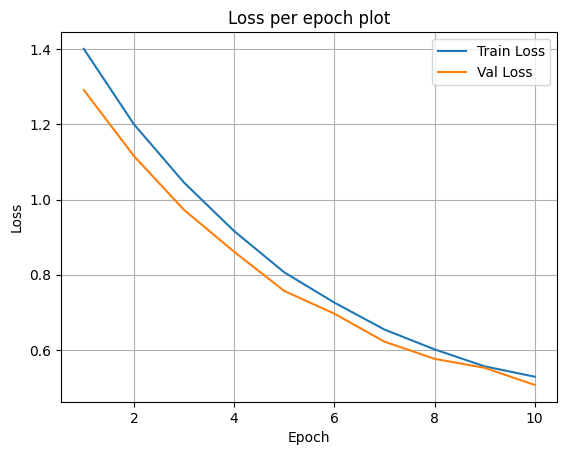

Saved best model at epoch 10 with val_loss 0.5066


Sampling: 100%|██████████| 1000/1000 [00:12<00:00, 80.50step/s]


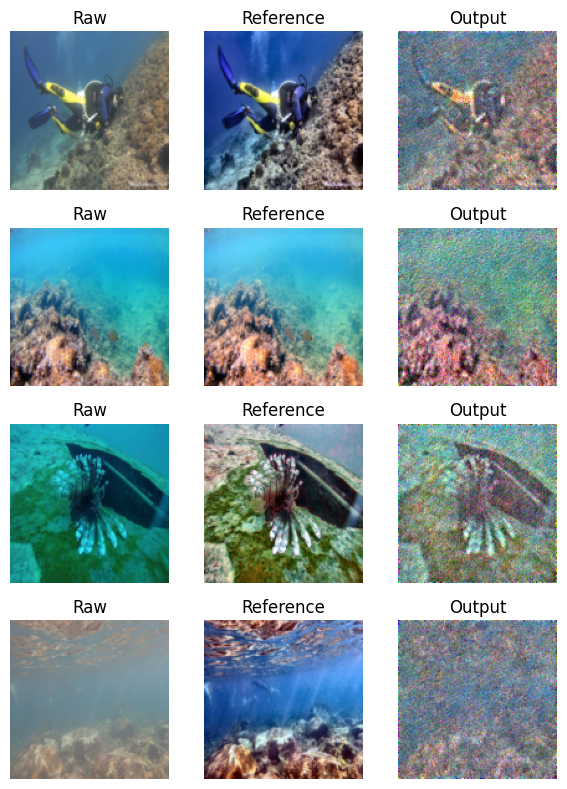

Epoch 11/100: 100%|██████████| 44/44 [00:18<00:00,  2.38batch/s]



==> Epoch 11 | Train loss: 0.4924 | Train PSNR: 13.25 dB
==> Epoch 11 | Val loss: 0.4968 | Val PSNR: 13.52 dB
Saved best model at epoch 11 with val_loss 0.4968


Epoch 12/100: 100%|██████████| 44/44 [00:18<00:00,  2.36batch/s]



==> Epoch 12 | Train loss: 0.4708 | Train PSNR: 12.57 dB
==> Epoch 12 | Val loss: 0.4570 | Val PSNR: 13.11 dB
Saved best model at epoch 12 with val_loss 0.4570


Epoch 13/100: 100%|██████████| 44/44 [00:18<00:00,  2.35batch/s]



==> Epoch 13 | Train loss: 0.4533 | Train PSNR: 13.25 dB
==> Epoch 13 | Val loss: 0.4418 | Val PSNR: 14.25 dB
Saved best model at epoch 13 with val_loss 0.4418


Epoch 14/100: 100%|██████████| 44/44 [00:18<00:00,  2.35batch/s]



==> Epoch 14 | Train loss: 0.4403 | Train PSNR: 13.30 dB
==> Epoch 14 | Val loss: 0.4322 | Val PSNR: 13.37 dB
Saved best model at epoch 14 with val_loss 0.4322


Epoch 15/100: 100%|██████████| 44/44 [00:18<00:00,  2.35batch/s]



==> Epoch 15 | Train loss: 0.4372 | Train PSNR: 13.27 dB
==> Epoch 15 | Val loss: 0.4421 | Val PSNR: 12.99 dB


Epoch 16/100: 100%|██████████| 44/44 [00:18<00:00,  2.34batch/s]



==> Epoch 16 | Train loss: 0.4197 | Train PSNR: 13.61 dB
==> Epoch 16 | Val loss: 0.3912 | Val PSNR: 13.87 dB
Saved best model at epoch 16 with val_loss 0.3912


Epoch 17/100: 100%|██████████| 44/44 [00:18<00:00,  2.36batch/s]



==> Epoch 17 | Train loss: 0.4051 | Train PSNR: 13.75 dB
==> Epoch 17 | Val loss: 0.4162 | Val PSNR: 13.37 dB


Epoch 18/100: 100%|██████████| 44/44 [00:18<00:00,  2.35batch/s]



==> Epoch 18 | Train loss: 0.3915 | Train PSNR: 13.76 dB
==> Epoch 18 | Val loss: 0.4103 | Val PSNR: 14.03 dB


Epoch 19/100: 100%|██████████| 44/44 [00:18<00:00,  2.35batch/s]



==> Epoch 19 | Train loss: 0.3829 | Train PSNR: 14.17 dB
==> Epoch 19 | Val loss: 0.3973 | Val PSNR: 13.29 dB


Epoch 20/100: 100%|██████████| 44/44 [00:18<00:00,  2.36batch/s]



==> Epoch 20 | Train loss: 0.3846 | Train PSNR: 13.91 dB
==> Epoch 20 | Val loss: 0.4068 | Val PSNR: 13.74 dB


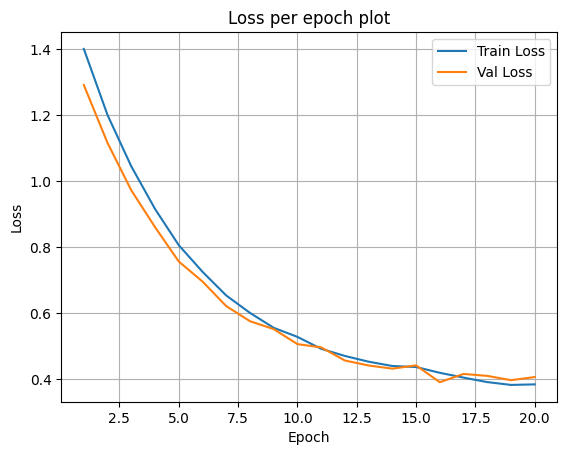

Sampling: 100%|██████████| 1000/1000 [00:12<00:00, 82.48step/s]


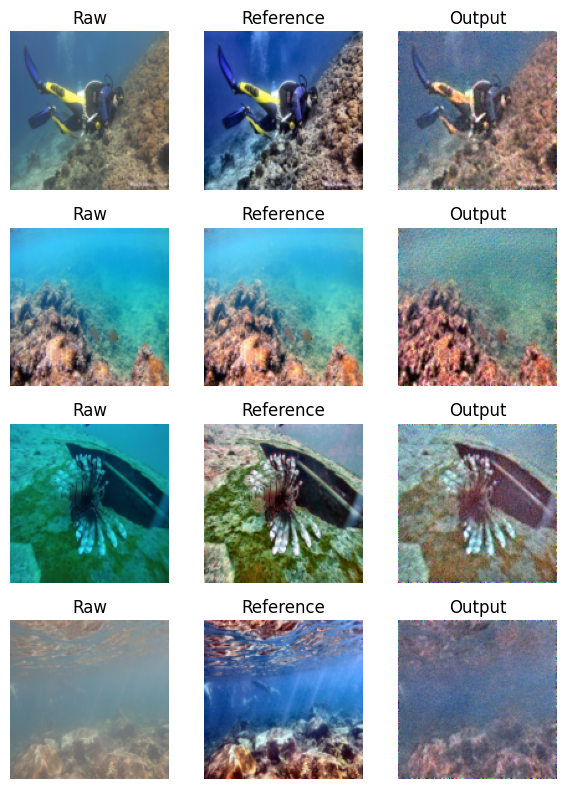

Epoch 21/100: 100%|██████████| 44/44 [00:18<00:00,  2.37batch/s]



==> Epoch 21 | Train loss: 0.3804 | Train PSNR: 14.28 dB
==> Epoch 21 | Val loss: 0.3843 | Val PSNR: 13.66 dB
Saved best model at epoch 21 with val_loss 0.3843


Epoch 22/100: 100%|██████████| 44/44 [00:18<00:00,  2.37batch/s]



==> Epoch 22 | Train loss: 0.3640 | Train PSNR: 14.37 dB
==> Epoch 22 | Val loss: 0.3891 | Val PSNR: 15.00 dB


Epoch 23/100: 100%|██████████| 44/44 [00:18<00:00,  2.34batch/s]



==> Epoch 23 | Train loss: 0.3707 | Train PSNR: 13.88 dB
==> Epoch 23 | Val loss: 0.4089 | Val PSNR: 14.50 dB


Epoch 24/100: 100%|██████████| 44/44 [00:18<00:00,  2.35batch/s]



==> Epoch 24 | Train loss: 0.3618 | Train PSNR: 14.32 dB
==> Epoch 24 | Val loss: 0.3600 | Val PSNR: 14.90 dB
Saved best model at epoch 24 with val_loss 0.3600


Epoch 25/100: 100%|██████████| 44/44 [00:18<00:00,  2.34batch/s]



==> Epoch 25 | Train loss: 0.3533 | Train PSNR: 14.32 dB
==> Epoch 25 | Val loss: 0.3330 | Val PSNR: 15.02 dB
Saved best model at epoch 25 with val_loss 0.3330


Epoch 26/100: 100%|██████████| 44/44 [00:18<00:00,  2.36batch/s]



==> Epoch 26 | Train loss: 0.3503 | Train PSNR: 14.34 dB
==> Epoch 26 | Val loss: 0.3441 | Val PSNR: 14.62 dB


Epoch 27/100: 100%|██████████| 44/44 [00:18<00:00,  2.34batch/s]



==> Epoch 27 | Train loss: 0.3531 | Train PSNR: 14.41 dB
==> Epoch 27 | Val loss: 0.3437 | Val PSNR: 15.40 dB


Epoch 28/100: 100%|██████████| 44/44 [00:18<00:00,  2.37batch/s]



==> Epoch 28 | Train loss: 0.3488 | Train PSNR: 14.59 dB
==> Epoch 28 | Val loss: 0.3290 | Val PSNR: 14.77 dB
Saved best model at epoch 28 with val_loss 0.3290


Epoch 29/100: 100%|██████████| 44/44 [00:18<00:00,  2.33batch/s]



==> Epoch 29 | Train loss: 0.3456 | Train PSNR: 14.84 dB
==> Epoch 29 | Val loss: 0.3271 | Val PSNR: 14.96 dB
Saved best model at epoch 29 with val_loss 0.3271


Epoch 30/100: 100%|██████████| 44/44 [00:18<00:00,  2.35batch/s]



==> Epoch 30 | Train loss: 0.3312 | Train PSNR: 15.20 dB
==> Epoch 30 | Val loss: 0.3359 | Val PSNR: 14.61 dB


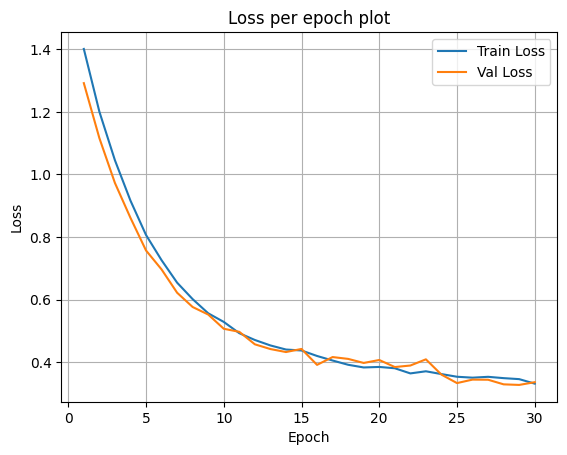

Sampling: 100%|██████████| 1000/1000 [00:12<00:00, 80.54step/s]


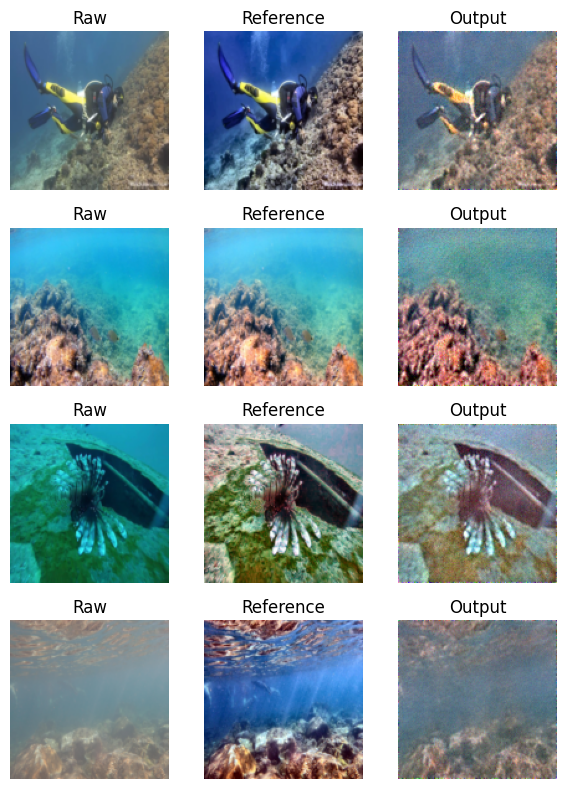

Epoch 31/100: 100%|██████████| 44/44 [00:18<00:00,  2.34batch/s]



==> Epoch 31 | Train loss: 0.3283 | Train PSNR: 14.70 dB
==> Epoch 31 | Val loss: 0.3224 | Val PSNR: 15.34 dB
Saved best model at epoch 31 with val_loss 0.3224


Epoch 32/100: 100%|██████████| 44/44 [00:18<00:00,  2.34batch/s]



==> Epoch 32 | Train loss: 0.3298 | Train PSNR: 15.01 dB
==> Epoch 32 | Val loss: 0.3209 | Val PSNR: 16.30 dB
Saved best model at epoch 32 with val_loss 0.3209


Epoch 33/100: 100%|██████████| 44/44 [00:18<00:00,  2.35batch/s]



==> Epoch 33 | Train loss: 0.3169 | Train PSNR: 15.42 dB
==> Epoch 33 | Val loss: 0.3370 | Val PSNR: 16.76 dB


Epoch 34/100: 100%|██████████| 44/44 [00:18<00:00,  2.35batch/s]



==> Epoch 34 | Train loss: 0.3236 | Train PSNR: 15.21 dB
==> Epoch 34 | Val loss: 0.3284 | Val PSNR: 13.95 dB


Epoch 35/100: 100%|██████████| 44/44 [00:18<00:00,  2.34batch/s]



==> Epoch 35 | Train loss: 0.3095 | Train PSNR: 15.54 dB
==> Epoch 35 | Val loss: 0.3153 | Val PSNR: 16.04 dB
Saved best model at epoch 35 with val_loss 0.3153


Epoch 36/100: 100%|██████████| 44/44 [00:18<00:00,  2.35batch/s]



==> Epoch 36 | Train loss: 0.3201 | Train PSNR: 15.05 dB
==> Epoch 36 | Val loss: 0.2960 | Val PSNR: 16.18 dB
Saved best model at epoch 36 with val_loss 0.2960


Epoch 37/100: 100%|██████████| 44/44 [00:18<00:00,  2.35batch/s]



==> Epoch 37 | Train loss: 0.3063 | Train PSNR: 15.87 dB
==> Epoch 37 | Val loss: 0.3006 | Val PSNR: 17.17 dB


Epoch 38/100: 100%|██████████| 44/44 [00:18<00:00,  2.36batch/s]



==> Epoch 38 | Train loss: 0.3090 | Train PSNR: 15.28 dB
==> Epoch 38 | Val loss: 0.3212 | Val PSNR: 15.95 dB


Epoch 39/100: 100%|██████████| 44/44 [00:18<00:00,  2.35batch/s]



==> Epoch 39 | Train loss: 0.3050 | Train PSNR: 15.19 dB
==> Epoch 39 | Val loss: 0.3060 | Val PSNR: 14.00 dB


Epoch 40/100: 100%|██████████| 44/44 [00:18<00:00,  2.35batch/s]



==> Epoch 40 | Train loss: 0.3046 | Train PSNR: 15.23 dB
==> Epoch 40 | Val loss: 0.3069 | Val PSNR: 16.01 dB


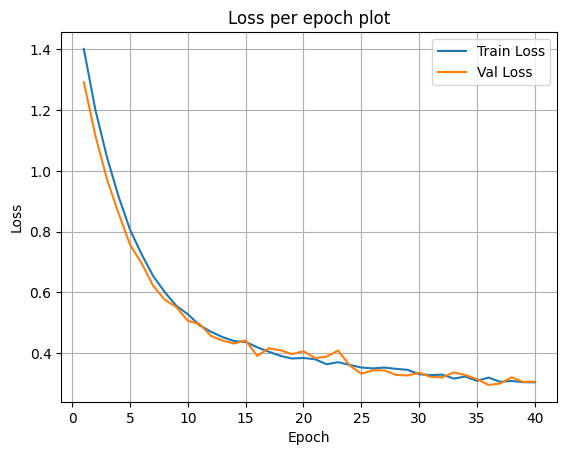

Sampling: 100%|██████████| 1000/1000 [00:12<00:00, 80.98step/s]


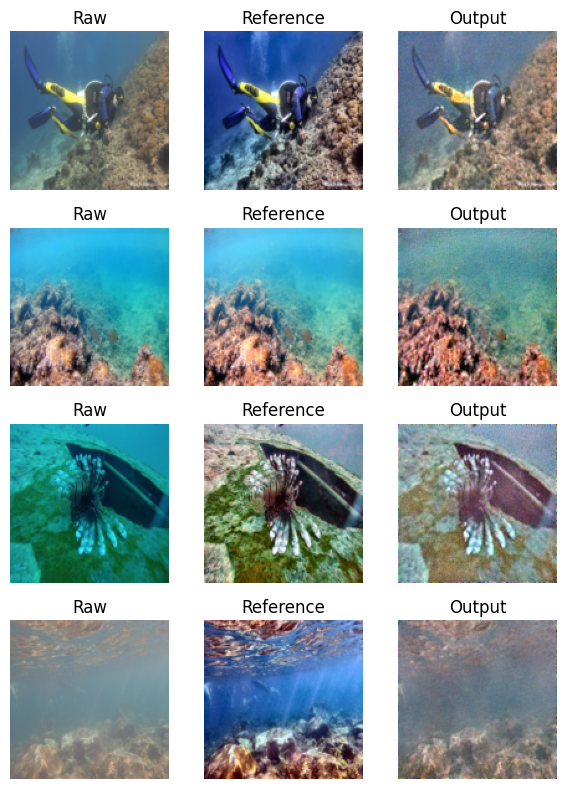

Epoch 41/100: 100%|██████████| 44/44 [00:18<00:00,  2.36batch/s]



==> Epoch 41 | Train loss: 0.2943 | Train PSNR: 15.56 dB
==> Epoch 41 | Val loss: 0.2895 | Val PSNR: 15.40 dB
Saved best model at epoch 41 with val_loss 0.2895


Epoch 42/100: 100%|██████████| 44/44 [00:18<00:00,  2.35batch/s]



==> Epoch 42 | Train loss: 0.3050 | Train PSNR: 15.90 dB
==> Epoch 42 | Val loss: 0.3219 | Val PSNR: 16.09 dB


Epoch 43/100: 100%|██████████| 44/44 [00:18<00:00,  2.37batch/s]



==> Epoch 43 | Train loss: 0.2985 | Train PSNR: 15.25 dB
==> Epoch 43 | Val loss: 0.2925 | Val PSNR: 15.09 dB


Epoch 44/100: 100%|██████████| 44/44 [00:18<00:00,  2.34batch/s]



==> Epoch 44 | Train loss: 0.3040 | Train PSNR: 15.49 dB
==> Epoch 44 | Val loss: 0.3118 | Val PSNR: 14.71 dB


Epoch 45/100: 100%|██████████| 44/44 [00:18<00:00,  2.34batch/s]



==> Epoch 45 | Train loss: 0.2848 | Train PSNR: 15.94 dB
==> Epoch 45 | Val loss: 0.2927 | Val PSNR: 15.62 dB


Epoch 46/100: 100%|██████████| 44/44 [00:18<00:00,  2.36batch/s]



==> Epoch 46 | Train loss: 0.2947 | Train PSNR: 15.69 dB
==> Epoch 46 | Val loss: 0.3064 | Val PSNR: 15.25 dB


Epoch 47/100: 100%|██████████| 44/44 [00:18<00:00,  2.35batch/s]



==> Epoch 47 | Train loss: 0.2892 | Train PSNR: 15.68 dB
==> Epoch 47 | Val loss: 0.3195 | Val PSNR: 15.49 dB


Epoch 48/100: 100%|██████████| 44/44 [00:18<00:00,  2.35batch/s]



==> Epoch 48 | Train loss: 0.2925 | Train PSNR: 15.65 dB
==> Epoch 48 | Val loss: 0.2782 | Val PSNR: 16.92 dB
Saved best model at epoch 48 with val_loss 0.2782


Epoch 49/100: 100%|██████████| 44/44 [00:18<00:00,  2.36batch/s]



==> Epoch 49 | Train loss: 0.2903 | Train PSNR: 15.61 dB
==> Epoch 49 | Val loss: 0.3200 | Val PSNR: 15.12 dB


Epoch 50/100: 100%|██████████| 44/44 [00:18<00:00,  2.35batch/s]



==> Epoch 50 | Train loss: 0.2780 | Train PSNR: 16.27 dB
==> Epoch 50 | Val loss: 0.2865 | Val PSNR: 16.02 dB


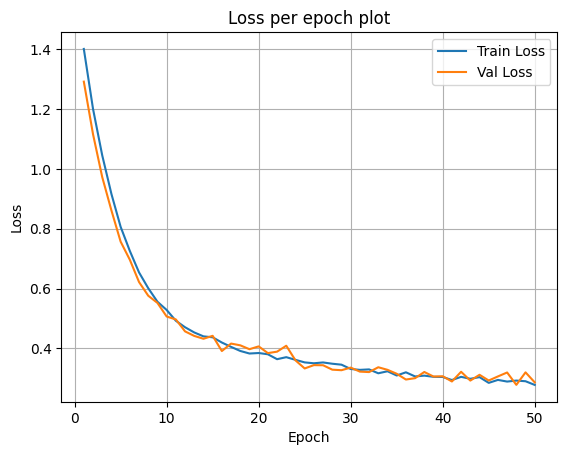

Sampling: 100%|██████████| 1000/1000 [00:12<00:00, 81.27step/s]


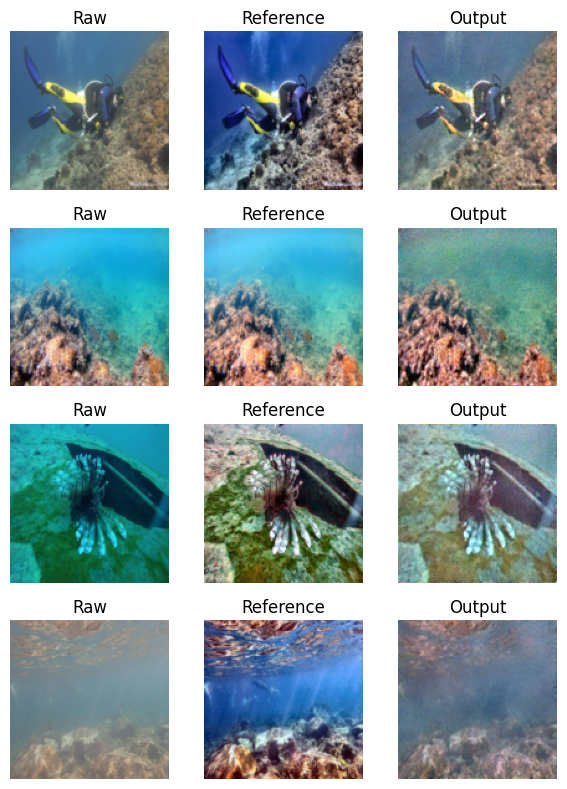

Epoch 51/100: 100%|██████████| 44/44 [00:18<00:00,  2.35batch/s]



==> Epoch 51 | Train loss: 0.2827 | Train PSNR: 15.75 dB
==> Epoch 51 | Val loss: 0.2875 | Val PSNR: 16.16 dB


Epoch 52/100: 100%|██████████| 44/44 [00:18<00:00,  2.35batch/s]



==> Epoch 52 | Train loss: 0.2821 | Train PSNR: 15.89 dB
==> Epoch 52 | Val loss: 0.2801 | Val PSNR: 17.00 dB


Epoch 53/100: 100%|██████████| 44/44 [00:18<00:00,  2.34batch/s]



==> Epoch 53 | Train loss: 0.2827 | Train PSNR: 15.71 dB
==> Epoch 53 | Val loss: 0.2948 | Val PSNR: 15.26 dB


Epoch 54/100: 100%|██████████| 44/44 [00:18<00:00,  2.34batch/s]



==> Epoch 54 | Train loss: 0.2771 | Train PSNR: 16.72 dB
==> Epoch 54 | Val loss: 0.2711 | Val PSNR: 16.31 dB
Saved best model at epoch 54 with val_loss 0.2711


Epoch 55/100: 100%|██████████| 44/44 [00:18<00:00,  2.35batch/s]



==> Epoch 55 | Train loss: 0.2783 | Train PSNR: 15.92 dB
==> Epoch 55 | Val loss: 0.2867 | Val PSNR: 15.34 dB


Epoch 56/100: 100%|██████████| 44/44 [00:18<00:00,  2.34batch/s]



==> Epoch 56 | Train loss: 0.2747 | Train PSNR: 15.71 dB
==> Epoch 56 | Val loss: 0.3005 | Val PSNR: 15.59 dB


Epoch 57/100: 100%|██████████| 44/44 [00:18<00:00,  2.36batch/s]



==> Epoch 57 | Train loss: 0.2687 | Train PSNR: 16.43 dB
==> Epoch 57 | Val loss: 0.2755 | Val PSNR: 16.08 dB


Epoch 58/100: 100%|██████████| 44/44 [00:18<00:00,  2.36batch/s]



==> Epoch 58 | Train loss: 0.2715 | Train PSNR: 16.12 dB
==> Epoch 58 | Val loss: 0.2849 | Val PSNR: 15.62 dB


Epoch 59/100: 100%|██████████| 44/44 [00:18<00:00,  2.35batch/s]



==> Epoch 59 | Train loss: 0.2720 | Train PSNR: 15.89 dB
==> Epoch 59 | Val loss: 0.2746 | Val PSNR: 15.61 dB


Epoch 60/100: 100%|██████████| 44/44 [00:18<00:00,  2.35batch/s]



==> Epoch 60 | Train loss: 0.2730 | Train PSNR: 15.82 dB
==> Epoch 60 | Val loss: 0.2757 | Val PSNR: 15.17 dB


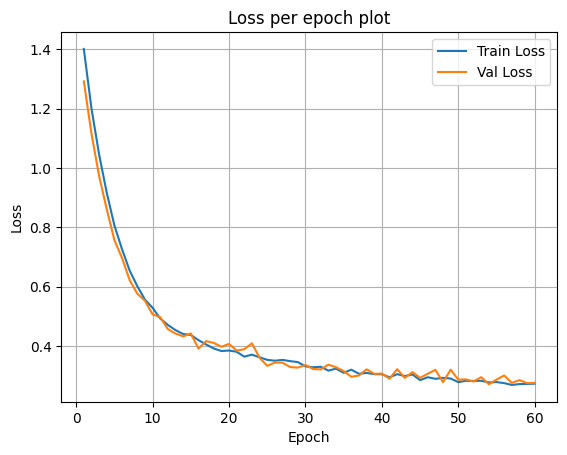

Sampling: 100%|██████████| 1000/1000 [00:12<00:00, 80.70step/s]


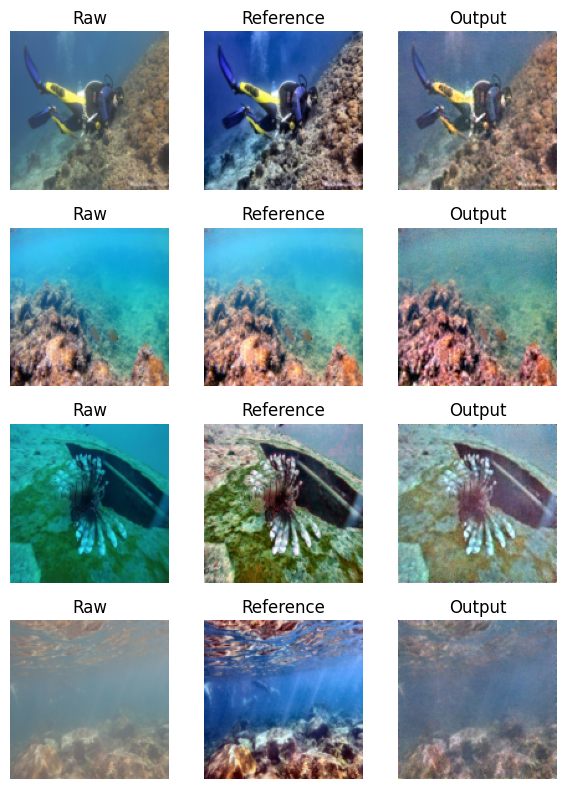

Epoch 61/100: 100%|██████████| 44/44 [00:18<00:00,  2.35batch/s]



==> Epoch 61 | Train loss: 0.2759 | Train PSNR: 16.37 dB
==> Epoch 61 | Val loss: 0.2832 | Val PSNR: 15.35 dB


Epoch 62/100: 100%|██████████| 44/44 [00:18<00:00,  2.36batch/s]



==> Epoch 62 | Train loss: 0.2731 | Train PSNR: 15.90 dB
==> Epoch 62 | Val loss: 0.2675 | Val PSNR: 16.15 dB
Saved best model at epoch 62 with val_loss 0.2675


Epoch 63/100: 100%|██████████| 44/44 [00:18<00:00,  2.35batch/s]



==> Epoch 63 | Train loss: 0.2759 | Train PSNR: 16.11 dB
==> Epoch 63 | Val loss: 0.2871 | Val PSNR: 14.76 dB


Epoch 64/100: 100%|██████████| 44/44 [00:18<00:00,  2.37batch/s]



==> Epoch 64 | Train loss: 0.2680 | Train PSNR: 16.17 dB
==> Epoch 64 | Val loss: 0.2875 | Val PSNR: 16.43 dB


Epoch 65/100: 100%|██████████| 44/44 [00:18<00:00,  2.34batch/s]



==> Epoch 65 | Train loss: 0.2625 | Train PSNR: 16.44 dB
==> Epoch 65 | Val loss: 0.2794 | Val PSNR: 15.19 dB


Epoch 66/100: 100%|██████████| 44/44 [00:18<00:00,  2.35batch/s]



==> Epoch 66 | Train loss: 0.2675 | Train PSNR: 16.01 dB
==> Epoch 66 | Val loss: 0.2754 | Val PSNR: 14.55 dB


Epoch 67/100: 100%|██████████| 44/44 [00:18<00:00,  2.37batch/s]



==> Epoch 67 | Train loss: 0.2729 | Train PSNR: 16.15 dB
==> Epoch 67 | Val loss: 0.2589 | Val PSNR: 16.37 dB
Saved best model at epoch 67 with val_loss 0.2589


Epoch 68/100: 100%|██████████| 44/44 [00:18<00:00,  2.36batch/s]



==> Epoch 68 | Train loss: 0.2646 | Train PSNR: 16.41 dB
==> Epoch 68 | Val loss: 0.2843 | Val PSNR: 17.43 dB


Epoch 69/100: 100%|██████████| 44/44 [00:18<00:00,  2.36batch/s]



==> Epoch 69 | Train loss: 0.2709 | Train PSNR: 16.34 dB
==> Epoch 69 | Val loss: 0.2765 | Val PSNR: 14.73 dB


Epoch 70/100: 100%|██████████| 44/44 [00:18<00:00,  2.36batch/s]



==> Epoch 70 | Train loss: 0.2686 | Train PSNR: 16.17 dB
==> Epoch 70 | Val loss: 0.2972 | Val PSNR: 17.23 dB


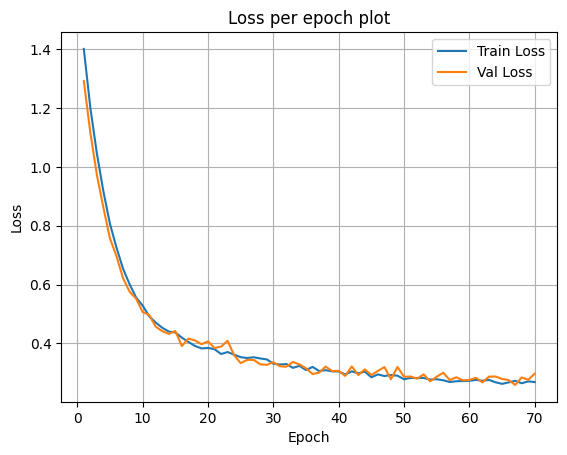

Sampling: 100%|██████████| 1000/1000 [00:12<00:00, 81.24step/s]


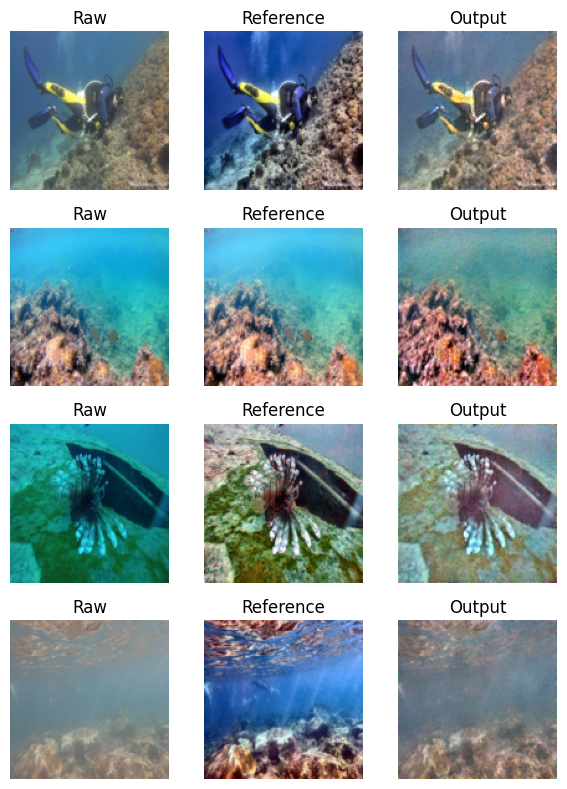

Epoch 71/100: 100%|██████████| 44/44 [00:18<00:00,  2.36batch/s]



==> Epoch 71 | Train loss: 0.2635 | Train PSNR: 15.96 dB
==> Epoch 71 | Val loss: 0.2895 | Val PSNR: 15.98 dB


Epoch 72/100: 100%|██████████| 44/44 [00:18<00:00,  2.34batch/s]



==> Epoch 72 | Train loss: 0.2702 | Train PSNR: 16.01 dB
==> Epoch 72 | Val loss: 0.2439 | Val PSNR: 17.06 dB
Saved best model at epoch 72 with val_loss 0.2439


Epoch 73/100: 100%|██████████| 44/44 [00:18<00:00,  2.35batch/s]



==> Epoch 73 | Train loss: 0.2716 | Train PSNR: 15.80 dB
==> Epoch 73 | Val loss: 0.2449 | Val PSNR: 16.73 dB


Epoch 74/100: 100%|██████████| 44/44 [00:18<00:00,  2.34batch/s]



==> Epoch 74 | Train loss: 0.2624 | Train PSNR: 16.77 dB
==> Epoch 74 | Val loss: 0.2873 | Val PSNR: 15.53 dB


Epoch 75/100: 100%|██████████| 44/44 [00:18<00:00,  2.33batch/s]



==> Epoch 75 | Train loss: 0.2625 | Train PSNR: 15.85 dB
==> Epoch 75 | Val loss: 0.2759 | Val PSNR: 16.21 dB


Epoch 76/100: 100%|██████████| 44/44 [00:18<00:00,  2.36batch/s]



==> Epoch 76 | Train loss: 0.2632 | Train PSNR: 16.53 dB
==> Epoch 76 | Val loss: 0.2942 | Val PSNR: 15.74 dB


Epoch 77/100: 100%|██████████| 44/44 [00:18<00:00,  2.36batch/s]



==> Epoch 77 | Train loss: 0.2617 | Train PSNR: 15.82 dB
==> Epoch 77 | Val loss: 0.2701 | Val PSNR: 15.34 dB


Epoch 78/100: 100%|██████████| 44/44 [00:18<00:00,  2.36batch/s]



==> Epoch 78 | Train loss: 0.2661 | Train PSNR: 16.27 dB
==> Epoch 78 | Val loss: 0.2812 | Val PSNR: 17.17 dB


Epoch 79/100: 100%|██████████| 44/44 [00:18<00:00,  2.36batch/s]



==> Epoch 79 | Train loss: 0.2685 | Train PSNR: 16.09 dB
==> Epoch 79 | Val loss: 0.2542 | Val PSNR: 16.36 dB


Epoch 80/100: 100%|██████████| 44/44 [00:18<00:00,  2.35batch/s]



==> Epoch 80 | Train loss: 0.2585 | Train PSNR: 16.40 dB
==> Epoch 80 | Val loss: 0.2579 | Val PSNR: 16.34 dB


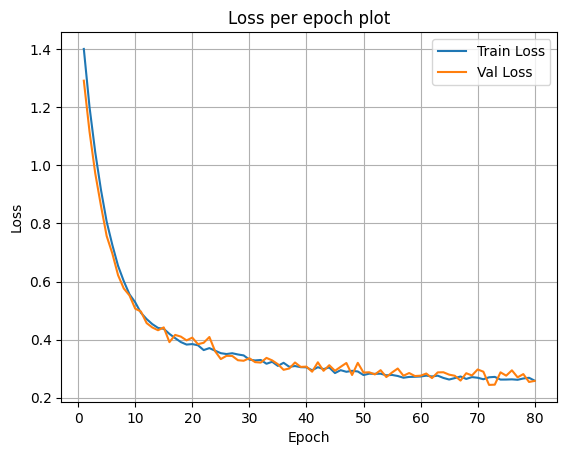

Sampling: 100%|██████████| 1000/1000 [00:12<00:00, 81.35step/s]


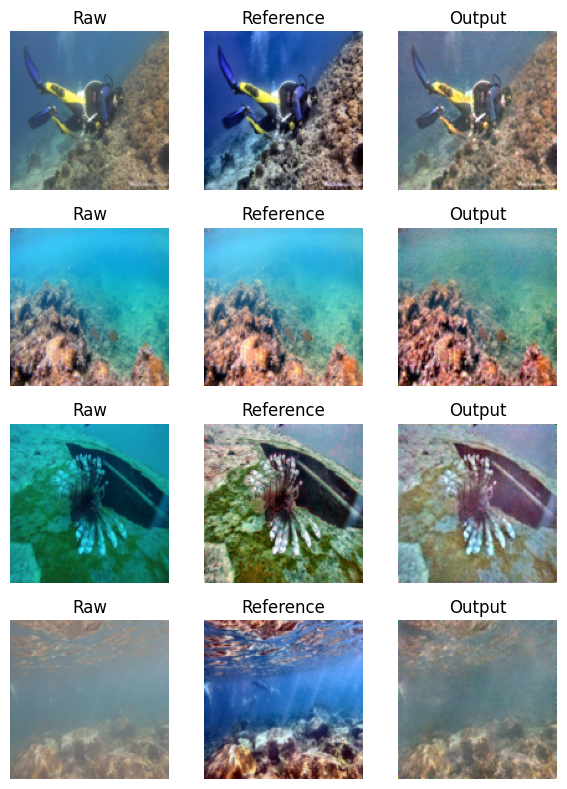

Epoch 81/100: 100%|██████████| 44/44 [00:18<00:00,  2.34batch/s]



==> Epoch 81 | Train loss: 0.2666 | Train PSNR: 16.00 dB
==> Epoch 81 | Val loss: 0.2711 | Val PSNR: 15.90 dB


Epoch 82/100: 100%|██████████| 44/44 [00:18<00:00,  2.36batch/s]



==> Epoch 82 | Train loss: 0.2604 | Train PSNR: 16.31 dB
==> Epoch 82 | Val loss: 0.2564 | Val PSNR: 16.80 dB


Epoch 83/100: 100%|██████████| 44/44 [00:18<00:00,  2.35batch/s]



==> Epoch 83 | Train loss: 0.2691 | Train PSNR: 15.87 dB
==> Epoch 83 | Val loss: 0.2520 | Val PSNR: 16.45 dB


Epoch 84/100: 100%|██████████| 44/44 [00:18<00:00,  2.35batch/s]



==> Epoch 84 | Train loss: 0.2590 | Train PSNR: 16.10 dB
==> Epoch 84 | Val loss: 0.2596 | Val PSNR: 16.51 dB


Epoch 85/100: 100%|██████████| 44/44 [00:18<00:00,  2.36batch/s]



==> Epoch 85 | Train loss: 0.2642 | Train PSNR: 16.34 dB
==> Epoch 85 | Val loss: 0.2676 | Val PSNR: 15.65 dB


Epoch 86/100: 100%|██████████| 44/44 [00:18<00:00,  2.36batch/s]



==> Epoch 86 | Train loss: 0.2636 | Train PSNR: 16.02 dB
==> Epoch 86 | Val loss: 0.2629 | Val PSNR: 15.84 dB


Epoch 87/100: 100%|██████████| 44/44 [00:18<00:00,  2.35batch/s]



==> Epoch 87 | Train loss: 0.2648 | Train PSNR: 16.01 dB
==> Epoch 87 | Val loss: 0.2717 | Val PSNR: 15.53 dB
No improvement for 15 epochs. Early stopping at epoch 87.
Training finished. Loss plots and records saved in ./Results_valid


In [7]:
per_step_train_loss, per_epoch_train_loss, per_epoch_val_loss, best_model_path = train_cond_ddpm(raw_dir, ref_dir,
                epochs=100, batch_size=16, lr=1e-5, image_size=128,
                n_steps=1000, sample_every=10, sample_steps=1000)

In [26]:
# ============ Test & Metrics ============ #
import os
import torch
import torch.nn.functional as F
from torchvision.utils import save_image
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim
import numpy as np
from PIL import Image
from scipy import ndimage
import lpips

# --- 设置 ---
device = "cuda" if torch.cuda.is_available() else "cpu"
model_path = "./model_plot/best_model(Hybrid).pth"
save_dir3 = "./Results_test"
save_dir4 = "./metrics"
os.makedirs(save_dir3, exist_ok=True)
os.makedirs(save_dir4, exist_ok=True)

# --- 初始化模型 ---
model = CondUNetCA(c_in=7, c_out=3, base=64, cond_dim=128).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# --- Feature Extractors ---
vit  = FeatureExtractor("vit_base_patch16_224", img_size=image_size, out_dim=128).to(device)
swin = FeatureExtractor("swin_base_patch4_window7_224", img_size=image_size, out_dim=128).to(device)
for p in vit.parameters(): p.requires_grad = False
for p in swin.parameters(): p.requires_grad = False
lpips_vgg = lpips.LPIPS(net='vgg').to(device)

# --- 测试 ---
all_psnr = []
all_ssim = []
all_uiqm = []   # 需要实现或用第三方库
all_uciqe = []  # 需要实现或用第三方库
all_lpips = []

def _uicm(img):
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]
    rg = R - G
    yb = 0.5*(R+G) - B
    mu_rg, mu_yb = np.mean(rg), np.mean(yb)
    sig_rg, sig_yb = np.std(rg), np.std(yb)
    return (-0.0268 * np.sqrt(mu_rg**2 + mu_yb**2)) + (0.1586 * np.sqrt(sig_rg**2 + sig_yb**2))

def _uism(img):
    gray = cv2.cvtColor((img*255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    sobel = ndimage.sobel(gray.astype(float))
    return np.mean(np.abs(sobel)) / 255.0

def _uiconm(img):
    gray = cv2.cvtColor((img*255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    return np.std(gray) / 255.0

def compute_uiqm(img):
    """
    UIQM: Underwater Image Quality Measure
    img: numpy array in [0,1], shape (H,W,3)
    """
    return 0.0282*_uicm(img) + 0.2953*_uism(img) + 3.5753*_uiconm(img)

def compute_uciqe(img):
    """
    UCIQE: Underwater Color Image Quality Evaluation
    img: numpy array in [0,1], shape (H,W,3)
    """
    lab = cv2.cvtColor((img*255).astype(np.uint8), cv2.COLOR_RGB2LAB)
    L, A, B = cv2.split(lab)
    L = L.astype(np.float32) / 255.0

    chroma = np.sqrt((A-128)**2 + (B-128)**2)
    chroma = chroma / 360.624

    # coefficients from original paper
    c1, c2, c3 = 0.4680, 0.2745, 0.2576
    uc = np.std(chroma)
    con_l = np.percentile(L, 99) - np.percentile(L, 1)
    mu_s = np.mean(chroma)

    con_l = max(con_l, 1e-6)

    return c1*uc + c2*con_l + c3*mu_s

with torch.no_grad():
    for idx, (raw, ref) in enumerate(dl_test):
        raw, ref = raw.to(device), ref.to(device)
        B, C, H, W = raw.shape
        B, C, H, W = ref.shape
        
        # 随机时间步 t
        pred, _ = sample_enhanced(model, diffusion, ref, vit, swin, num_steps=diffusion.n_steps, use_dynamic_thres=True)
        # pred = pred[0]
        # 转换到 [0,1] 用于保存和计算指标
        pred01 = ((pred + 1) / 2.0).cpu().clamp(0,1)
        ref01  = ((ref + 1) / 2.0).cpu().clamp(0,1)

        pred_lpips = pred01 * 2 - 1
        ref_lpips = ref01 * 2 - 1

        for b in range(B):
            # 保存图片
            save_image(pred01[b], os.path.join(save_dir3, f"test_{idx*B + b:03d}.png"))

            # 转为 numpy
            pred_np = pred01[b].permute(1,2,0).numpy()
            ref_np  = ref01[b].permute(1,2,0).numpy()
            pred_uint8 = (pred_np * 255).astype(np.uint8)

            # PSNR / SSIM
            psnr_val = compare_psnr(ref_np, pred_np, data_range=1.0)
            ssim_val = compare_ssim(ref_np, pred_np, channel_axis=2, data_range=1.0)
            all_psnr.append(psnr_val)
            all_ssim.append(ssim_val)

            # UIQM / UCIQE 可用第三方库函数
            uiqm_val = compute_uiqm(pred_uint8)
            uciqe_val = compute_uciqe(pred_uint8)
            all_uiqm.append(uiqm_val)
            all_uciqe.append(uciqe_val)

            # LPIPS
            lpips_val = lpips_vgg(pred_lpips[b:b+1].to(device), ref_lpips[b:b+1].to(device))
            all_lpips.append(lpips_val.item())

# --- 输出指标平均值 ---
print(f"Average PSNR: {np.mean(all_psnr):.2f}")
print(f"Average SSIM: {np.mean(all_ssim):.4f}")
print(f"Average UIQM: {np.mean(all_uiqm):.4f}")
print(f"Average UCIQE: {np.mean(all_uciqe):.4f}")
print(f"Average LPIPS: {np.mean(all_lpips):.4f}")
print(f"All test images saved to {save_dir3}")

# --- Save results to txt ---
results_file = os.path.join(save_dir4, "results.txt")
with open(results_file, "w") as f:
    f.write(f"Average PSNR:  {np.mean(all_psnr):.2f}\n")
    f.write(f"Average SSIM:  {np.mean(all_ssim):.4f}\n")
    f.write(f"Average UIQM:  {np.mean(all_uiqm):.4f}\n")
    f.write(f"Average UCIQE: {np.mean(all_uciqe):.4f}\n")
    f.write(f"Average LPIPS: {np.mean(all_lpips):.4f}\n")

/home/jing/anaconda3/envs/UIEB/lib/python3.12/site-packages/timm/layers/interpolate.py:65: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  numerator += self.values[as_s] * \
/home/jing/anaconda3/envs/UIEB/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jing/anaconda3/envs/UIEB/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior i

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/jing/anaconda3/envs/UIEB/lib/python3.12/site-packages/lpips/weights/v0.1/vgg.pth


Sampling: 100%|██████████| 1000/1000 [00:07<00:00, 132.67step/s]


Average PSNR: 16.39
Average SSIM: 0.6958
Average UIQM: 1.0919
Average UCIQE: 0.2163
Average LPIPS: 0.3036
All test images saved to ./Results_test


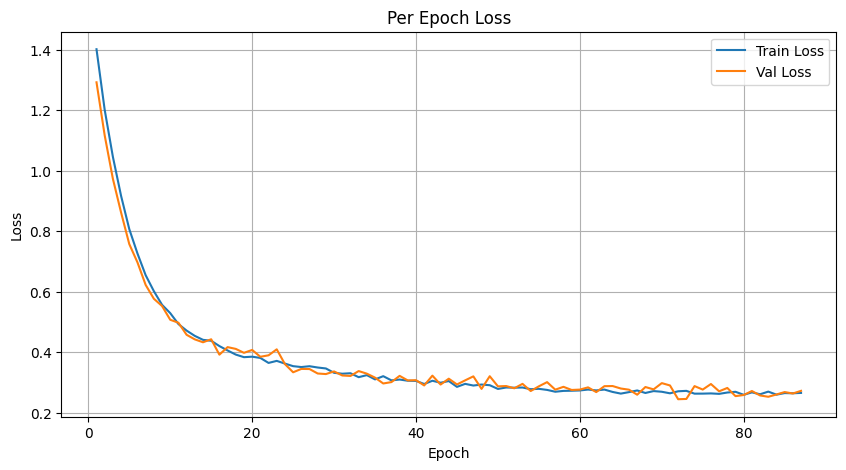

In [9]:
import torch
import matplotlib.pyplot as plt

# Load the loss dictionary
losses = torch.load("./model_plot/loss_records.pth")  # 改成你的路径
per_epoch_train_loss = losses["per_epoch_train_loss"]
per_epoch_val_loss   = losses["per_epoch_val_loss"]

# Plot
plt.figure(figsize=(10,5))
plt.plot(range(1, len(per_epoch_train_loss)+1), per_epoch_train_loss, label="Train Loss")
plt.plot(range(1, len(per_epoch_val_loss)+1), per_epoch_val_loss, label="Val Loss")
plt.title("Per Epoch Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

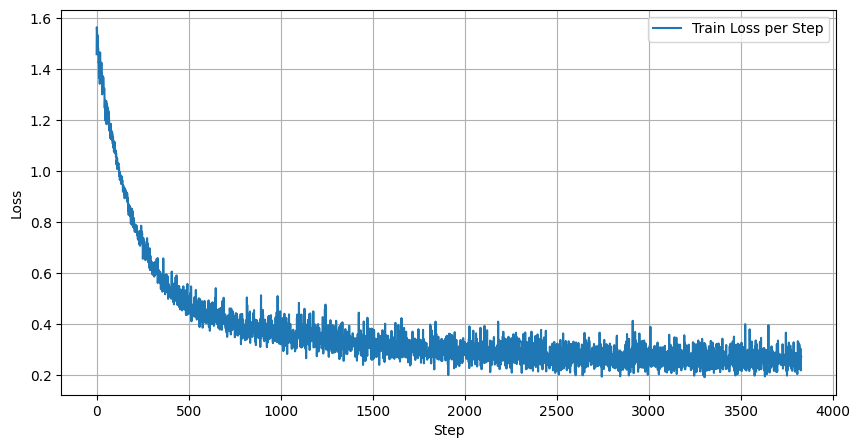

In [10]:
save_dir5 = "./Results_valid"
os.makedirs(save_dir5, exist_ok=True)

per_step_train_loss = losses["per_step_train_loss"]
plt.figure(figsize=(10,5))
plt.plot(per_step_train_loss, label="Train Loss per Step")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_dir5, "loss_per_step.png"))
plt.show()

In [11]:
import torch
import pandas as pd
import numpy as np

losses = torch.load("./model_plot/loss_records.pth")
per_step_train_loss  = losses["per_step_train_loss"]
per_epoch_train_loss = losses["per_epoch_train_loss"]
per_epoch_val_loss   = losses["per_epoch_val_loss"]

# 找到最长长度
max_len = max(len(per_step_train_loss), len(per_epoch_train_loss), len(per_epoch_val_loss))

# 用 NaN 填充短的列
per_step_train_loss  = per_step_train_loss + [np.nan]*(max_len - len(per_step_train_loss))
per_epoch_train_loss = per_epoch_train_loss + [np.nan]*(max_len - len(per_epoch_train_loss))
per_epoch_val_loss   = per_epoch_val_loss + [np.nan]*(max_len - len(per_epoch_val_loss))

df = pd.DataFrame({
    "step_train_loss": per_step_train_loss,
    "epoch_train_loss": per_epoch_train_loss,
    "epoch_val_loss": per_epoch_val_loss
})

df.to_csv("./loss_records.csv", index=False)
print("Losses saved to ./UIEB-Test/loss_records.csv")
print(df.head(20))


Losses saved to ./UIEB-Test/loss_records.csv
    step_train_loss  epoch_train_loss  epoch_val_loss
0          1.458421          1.401082        1.291703
1          1.564423          1.200578        1.116026
2          1.550915          1.045302        0.972677
3          1.505337          0.916192        0.861152
4          1.477838          0.806403        0.756910
5          1.533921          0.725812        0.696302
6          1.479187          0.653995        0.621817
7          1.478502          0.601311        0.576128
8          1.484766          0.556041        0.552094
9          1.472932          0.528531        0.506615
10         1.466254          0.492449        0.496823
11         1.424062          0.470774        0.456950
12         1.429664          0.453345        0.441786
13         1.366535          0.440274        0.432221
14         1.432322          0.437194        0.442119
15         1.442289          0.419663        0.391228
16         1.415981          0.405136